In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="../weights",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="../weights",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%
100.0%
100.0%
100.0%


In [7]:
batch_size = 64

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
X, y = next(iter(train_loader))

for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


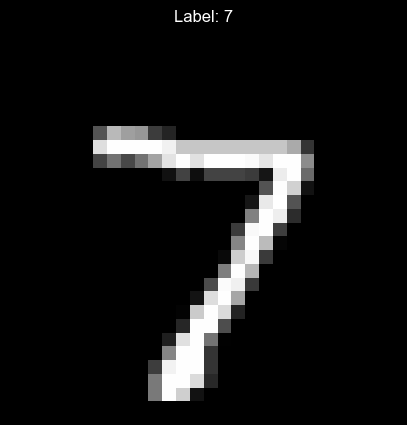

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


def show_image_seaborn(img, label):
    plt.figure(figsize=(5, 5))
    sns.heatmap(img.squeeze(), cmap="gray", cbar=False, xticklabels=False, yticklabels=False)
    plt.title(f"Label: {label}")
    plt.show()


show_image_seaborn(X[0], y[0].item())

In [9]:
# Get cpu, gpu device for training.
print(f"Torch Version: {torch.__version__}")
print(f"CUDA Version (torch): {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"Dispositivo: {torch.cuda.get_device_name(0)}")
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Torch Version: 2.10.0+cu130
CUDA Version (torch): 13.0
Dispositivo: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using cuda device


In [10]:
# Define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
x = X[:1].to(device)
model(x)

tensor([[-0.0381, -0.0303,  0.0414, -0.0148,  0.0076, -0.0346,  0.0250, -0.0070,
          0.0036, -0.0083]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [12]:
list(model.linear_relu_stack[0].parameters())

[Parameter containing:
 tensor([[ 0.0112,  0.0168, -0.0065,  ...,  0.0317, -0.0240, -0.0327],
         [ 0.0295,  0.0218,  0.0159,  ..., -0.0255, -0.0154, -0.0292],
         [-0.0090,  0.0280,  0.0275,  ...,  0.0354, -0.0352, -0.0290],
         ...,
         [ 0.0029, -0.0043, -0.0045,  ...,  0.0030,  0.0158,  0.0322],
         [-0.0029,  0.0036, -0.0248,  ..., -0.0282, -0.0082, -0.0136],
         [ 0.0159, -0.0225, -0.0078,  ...,  0.0018, -0.0055, -0.0243]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0199, -0.0213, -0.0356,  0.0312, -0.0241, -0.0343,  0.0287, -0.0092,
          0.0340,  0.0185,  0.0091, -0.0213, -0.0160, -0.0217, -0.0098,  0.0065,
          0.0116, -0.0086,  0.0190,  0.0149, -0.0192,  0.0324, -0.0251,  0.0239,
         -0.0112,  0.0129, -0.0164,  0.0265,  0.0190, -0.0173,  0.0027, -0.0183,
          0.0117, -0.0277,  0.0096,  0.0071,  0.0315, -0.0223, -0.0174,  0.0128,
         -0.0192,  0.0186, -0.0033,  0.0044, -0.0323, -0.0137,

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [16]:
import time
start = time.time()
epochs = 5
test(test_loader, model, loss_fn)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done in ", time.time() - start, "seconds.")

Test Error: 
 Accuracy: 10.2%, Avg loss: 2.303416 

Epoch 1
-------------------------------
loss: 2.306710  [    0/60000]
loss: 2.303918  [ 6400/60000]
loss: 2.294204  [12800/60000]
loss: 2.295949  [19200/60000]
loss: 2.286771  [25600/60000]
loss: 2.280542  [32000/60000]
loss: 2.270997  [38400/60000]
loss: 2.280334  [44800/60000]
loss: 2.265150  [51200/60000]
loss: 2.263386  [57600/60000]
Test Error: 
 Accuracy: 44.1%, Avg loss: 2.258849 

Epoch 2
-------------------------------
loss: 2.260542  [    0/60000]
loss: 2.254341  [ 6400/60000]
loss: 2.257848  [12800/60000]
loss: 2.235020  [19200/60000]
loss: 2.238485  [25600/60000]
loss: 2.231320  [32000/60000]
loss: 2.215099  [38400/60000]
loss: 2.236560  [44800/60000]
loss: 2.205826  [51200/60000]
loss: 2.203989  [57600/60000]
Test Error: 
 Accuracy: 66.6%, Avg loss: 2.196244 

Epoch 3
-------------------------------
loss: 2.196597  [    0/60000]
loss: 2.183880  [ 6400/60000]
loss: 2.203177  [12800/60000]
loss: 2.146189  [19200/60000]
loss

In [19]:
start = time.time()
epochs = 95
test(test_loader, model, loss_fn)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done in ", time.time() - start, "seconds.")

Test Error: 
 Accuracy: 72.8%, Avg loss: 1.612056 

Epoch 1
-------------------------------
loss: 1.626458  [    0/60000]
loss: 1.548995  [ 6400/60000]
loss: 1.650334  [12800/60000]
loss: 1.433250  [19200/60000]
loss: 1.464676  [25600/60000]
loss: 1.435431  [32000/60000]
loss: 1.373410  [38400/60000]
loss: 1.508059  [44800/60000]
loss: 1.359896  [51200/60000]
loss: 1.323620  [57600/60000]
Test Error: 
 Accuracy: 75.3%, Avg loss: 1.285208 

Epoch 2
-------------------------------
loss: 1.328705  [    0/60000]
loss: 1.221953  [ 6400/60000]
loss: 1.330881  [12800/60000]
loss: 1.137837  [19200/60000]
loss: 1.154189  [25600/60000]
loss: 1.124412  [32000/60000]
loss: 1.072817  [38400/60000]
loss: 1.228875  [44800/60000]
loss: 1.109973  [51200/60000]
loss: 1.061962  [57600/60000]
Test Error: 
 Accuracy: 78.7%, Avg loss: 1.026756 

Epoch 3
-------------------------------
loss: 1.100508  [    0/60000]
loss: 0.976993  [ 6400/60000]
loss: 1.072992  [12800/60000]
loss: 0.929627  [19200/60000]
loss

In [20]:
preds = model(X.to(device))
preds

tensor([[  1.0982,  -6.2945,   2.8717,   3.7953,  -4.3522,  -0.0259,  -8.9193,
           9.7012,  -0.3841,   2.9270],
        [  3.5577,  -0.8030,   9.8070,   5.4645, -10.1232,   3.2213,   4.4077,
          -8.8510,   2.2675,  -8.8998],
        [ -5.6424,   6.3494,   1.2674,   0.3567,  -1.5939,  -0.2124,  -0.1403,
           0.7983,   0.4748,  -2.0508],
        [ 11.3917, -12.0343,   2.8377,  -0.3463,  -6.1899,   3.0261,   1.6825,
           0.3308,   0.2076,   0.1232],
        [ -1.2799,  -6.7455,   0.4093,  -2.8538,   6.9129,  -0.5899,   0.3805,
           0.9622,   0.4429,   3.4206],
        [ -7.1537,   7.5657,   0.9538,   1.1664,  -1.9223,  -1.3030,  -2.3588,
           2.4416,   1.0329,  -0.7722],
        [ -4.5124,  -4.8262,  -3.7733,  -0.9931,   7.9162,   2.1766,  -2.1283,
           0.7439,   3.1912,   3.2901],
        [ -6.5002,  -0.7971,  -0.7856,   1.1646,   1.7775,   0.3500,  -3.6136,
           1.2797,   1.5422,   5.8531],
        [  1.1486,  -6.1332,   2.1579,  -5.9013,

In [21]:
loss_fn(preds[0].to(device), y[0].to(device))

tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)

In [22]:
# Save (inside your training notebook)
torch.save(model.state_dict(), "../weights/mnist_model.pth")
print("Saved PyTorch Model State to mnist_model.pth")

Saved PyTorch Model State to mnist_model.pth
